GSEAPY Example
-----------------------------------------------
Examples to use ``GSEApy`` inside python console

In [1]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import pandas as pd
import gseapy as gp
import matplotlib.pyplot as plt

**Check gseapy version**

In [2]:
gp.__version__

'0.12.1'

## 1.  (Optional) Convert IDs Using Biomart API  

Don't use this if you don't know Biomart
```python
from gseapy import Biomart 
bm = Biomart()
## view validated marts
marts = bm.get_marts()
## view validated dataset
datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
## view validated attributes
attrs = bm.get_attributes(dataset='hsapiens_gene_ensembl') 
## view validated filters
filters = bm.get_filters(dataset='hsapiens_gene_ensembl')
## query results
queries = ['ENSG00000125285','ENSG00000182968'] # need to be a python list
results = bm.query(dataset='hsapiens_gene_ensembl', 
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                   filters={'ensemble_gene_id': queries})
```

###  Mouse gene symbols maps to Human, or vice versa

This is useful when you have troubles to convert gene symbols between human and mouse

In [3]:
from gseapy import Biomart 
bm = Biomart()
m2h = bm.query_simple(dataset='mmusculus_gene_ensembl',
                          attributes=['ensembl_gene_id','external_gene_name',
                                      'hsapiens_homolog_ensembl_gene',
                                      'hsapiens_homolog_associated_gene_name'])

h2m = bm.query_simple(dataset='hsapiens_gene_ensembl',
                          attributes=['ensembl_gene_id','external_gene_name',
                                      'mmusculus_homolog_ensembl_gene',
                                      'mmusculus_homolog_associated_gene_name'])

In [4]:
h2m.sample(10)

,ensembl_gene_id,external_gene_name,mmusculus_homolog_ensembl_gene,mmusculus_homolog_associated_gene_name
64215,ENSG00000145041,DCAF1,ENSMUSG00000040325,Dcaf1
40327,ENSG00000226509,NaN,NaN,NaN
41799,ENSG00000023608,SNAPC1,ENSMUSG00000021113,Snapc1
27206,ENSG00000259454,WBP1LP5,NaN,NaN
8193,ENSG00000230926,NaN,NaN,NaN
7748,ENSG00000229310,RPP40P1,NaN,NaN
43171,ENSG00000137094,DNAJB5,ENSMUSG00000036052,Dnajb5
4045,ENSG00000223698,GOLGA6L11P,NaN,NaN
70911,ENSG00000233275,NaN,NaN,NaN
48882,ENSG00000212538,U3,NaN,NaN


## 2. Enrichr Example

Over-representation analysis using Enrichr web services.

The only requiment is a list of gene symbols.


**See all supported enrichr library names**  

Select database from **{ 'Human', 'Mouse', 'Yeast', 'Fly', 'Fish', 'Worm' }**

In [5]:
# default: Human
names = gp.get_library_name()
names[:10]

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021']

In [6]:
# yeast
yeast = gp.get_library_name(organism='Yeast') 
yeast[:10]

['Cellular_Component_AutoRIF',
 'Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_zscore',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_zscore',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF']

### 2.1  Inputs to enrichr

- `gene_list` accepts
    - ``pd.Series``
    -  ``pd.DataFrame`` 
    -  ``list`` object
    - ``txt`` file (one gene symbol per row)


- `gene_sets` accepts:

    Multi-libraries names supported, separate each name by comma or input a list. 

For example:
```python
    # gene_list
    gene_list="./data/gene_list.txt", 
    gene_list=glist
    # gene_sets
    gene_sets='KEGG_2016'  
    gene_sets='KEGG_2016,KEGG_2013'
    gene_sets=['KEGG_2016','KEGG_2013']
```

In [7]:
# read in an example gene list
gene_list = pd.read_csv("./tests/data/gene_list.txt",header=None, sep="\t")
gene_list.head()

,0
0,IGKV4-1
1,CD55
2,IGKC
3,PPFIBP1
4,ABHD4


In [8]:
# convert dataframe or series to list
glist = gene_list.squeeze().str.strip().to_list()
print(glist[:10])

['IGKV4-1', 'CD55', 'IGKC', 'PPFIBP1', 'ABHD4', 'PCSK6', 'PGD', 'ARHGDIB', 'ITGB2', 'CARD6']


### 2.2  Run 

In [9]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set outdir=None
enr = gp.enrichr(gene_list="./tests/data/gene_list.txt", 
                 gene_sets=['KEGG_2016','KEGG_2021_Human'], 
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk               
                )

In [10]:
# obj.results stores all results
enr.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2016,Osteoclast differentiation Homo sapiens hsa04380,28/132,3.104504e-13,7.885440e-11,0,0,6.659625,191.802220,LILRA6;ITGB3;LILRA2;LILRA5;PPP3R1;FCGR3B;SIRPA...
1,KEGG_2016,Tuberculosis Homo sapiens hsa05152,31/178,4.288559e-12,5.446470e-10,0,0,5.224941,136.763196,RAB5B;ITGB2;PPP3R1;HLA-DMA;FCGR3B;HLA-DMB;CASP...
2,KEGG_2016,Phagosome Homo sapiens hsa04145,28/154,1.614009e-11,1.366528e-09,0,0,5.490501,136.437381,ATP6V1A;RAB5B;ITGB5;ITGB3;ITGB2;HLA-DMA;FCGR3B...
3,KEGG_2016,Rheumatoid arthritis Homo sapiens hsa05323,19/90,2.197884e-09,1.395656e-07,0,0,6.554453,130.668081,ATP6V1A;ATP6V1G1;ATP6V0B;TGFB1;ITGB2;FOS;ITGAL...
4,KEGG_2016,Leishmaniasis Homo sapiens hsa05140,17/73,3.132614e-09,1.591368e-07,0,0,7.422186,145.336773,TGFB1;IFNGR1;PRKCB;IFNGR2;ITGB2;FOS;MAPK14;HLA...


### 2.3 Run locally  
If input a .gmt file or gene_set dict object, enrichr runs local.  
**You have to specify the background genes, if local mode used**

For example:
```python
    gene_sets="./data/genes.gmt",
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```


In [11]:
enr2 = gp.enrichr(gene_list="./tests/data/gene_list.txt", # or gene_list=glist
                 gene_sets="./tests/data/genes.gmt",
                 background='hsapiens_gene_ensembl', # or the number of genes, e.g 20000
                 outdir=None, 
                 verbose=True)

2022-08-17 15:25:50,433 Connecting to Enrichr Server to get latest library names
2022-08-17 15:25:50,434 User Defined gene sets is given: ./tests/data/genes.gmt
2022-08-17 15:25:50,484 Using all annotated genes with GO_ID as background: hsapiens_gene_ensembl
2022-08-17 15:25:50,495 Background: found 24978 genes


In [12]:
enr2.results.head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Genes
0,CUSTOM139850856508352,BvA_UpIN_A,8/130,0.029765,0.069452,2.343931,MAP3K5;PCSK6;IQGAP2;HAL;IL1R1;PADI2;MBOAT2;MSRB2
1,CUSTOM139850856508352,BvA_UpIN_B,11/124,0.000729,0.005100,3.339341,IL1RAP;MBNL3;SYK;KCTD12;DYSF;GPX8;SUOX;HEBP1;S...
2,CUSTOM139850856508352,CvA_UpIN_A,1/11,0.267894,0.375052,4.669004,MBOAT2
3,CUSTOM139850856508352,DvA_UpIN_A,16/259,0.002705,0.009466,2.302945,KIF1B;MAP3K5;VNN1;PCSK6;IQGAP2;HAL;IL1R1;ATP6V...
4,CUSTOM139850856508352,DvA_UpIN_D,11/218,0.043392,0.075936,1.895541,IL1RAP;TXNDC5;GNB4;MBNL3;DYSF;GPX8;GLIPR2;SIRP...


### 2.4 Plotting

Show top 5 terms of each gene_set ranked by "Adjusted P-value"

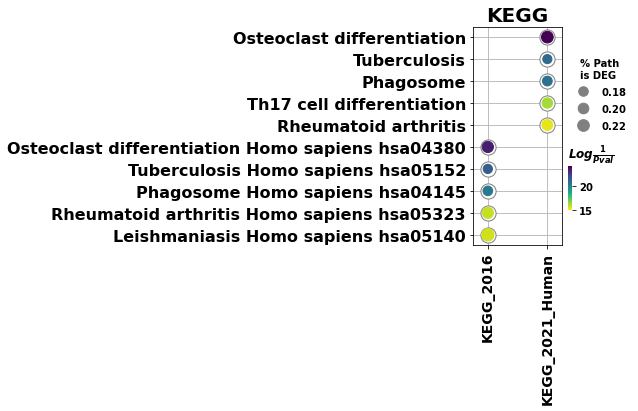

In [13]:
from gseapy import ringplot
ax = ringplot(enr.results, x='Gene_set', # set x, so you could do a multi-sample/dataset comparsion
              column="Adjusted P-value", 
              size=20, 
              top_term=5,
              figsize=(2,4), 
              title = "KEGG"
             )

In [14]:
# simple plotting function
from gseapy import barplot, dotplot

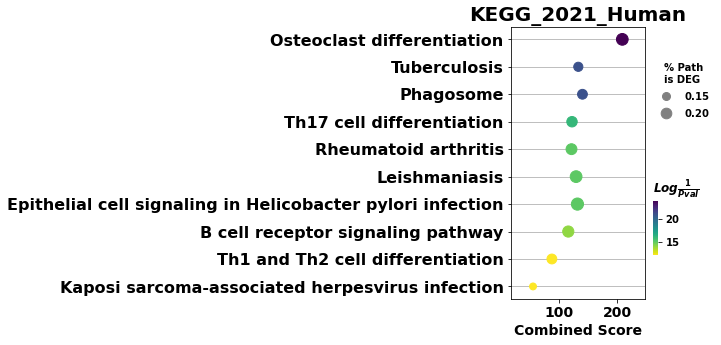

In [15]:
# to save your figure, make sure that ``ofname`` is not None
ax = dotplot(enr.res2d, title='KEGG_2021_Human',cmap='viridis_r', size=20, figsize=(3,5))

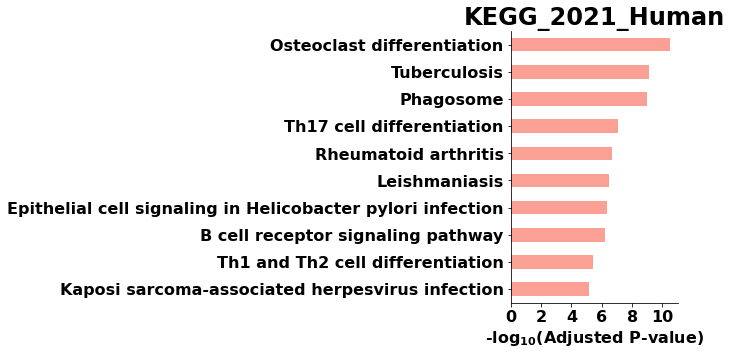

In [16]:
# to save your figure, make sure that ``ofname`` is not None
ax = barplot(enr.res2d,title='KEGG_2021_Human', figsize=(3, 5))

### 2.5 Command line usage 

You may also want to use enrichr in command line  

the option **-v** will print out the progress of your job

In [17]:
# !gseapy enrichr -i ./data/gene_list.txt \
#                 --ds BP2017 \
#                 -g GO_Biological_Process_2017 \
#                 -v -o test/enrichr_BP

## 3. Prerank example

### 3.1 Assign prerank() with 

- pd.DataFrame: Only contains two columns, or one cloumn with gene_name indexed 
- pd.Series 
- a txt file: 
  - **GSEApy will skip any data after "#".** 
  - Do not include header in your gene list !  


#### Supported gene_sets input
For example:
```python
    gene_sets="KEGG_2016",
    gene_sets="KEGG_2016,KEGG2013",
    gene_sets="./data/genes.gmt",
    gene_sets=["KEGG_2016","./data/genes.gmt"],
    gene_sets={'A':['gene1', 'gene2',...],
               'B':['gene2', 'gene4',...],
               ...}
```

In [18]:
rnk = pd.read_csv("./tests/data/temp.rnk", header=None, index_col=0, sep="\t")
rnk.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [19]:
rnk.shape

(22922, 1)

In [20]:
# # run prerank
# # enrichr libraries are supported by prerank module. Just provide the name
# # use 4 process to acceralate the permutation speed
pre_res = gp.prerank(rnk="./tests/data/temp.rnk", # or rnk = rnk,
                     gene_sets='KEGG_2016', 
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk 
                     seed=6, 
                     verbose=True, # see what's going on behind the scenes
                    )

2022-08-17 15:25:51,696 Parsing data files for GSEA.............................
2022-08-17 15:25:51,697 Enrichr library gene sets already downloaded in: /home/fangzq/.cache/gseapy, use local file
2022-08-17 15:25:51,708 0001 gene_sets have been filtered out when max_size=1000 and min_size=5
2022-08-17 15:25:51,709 0292 gene_sets used for further statistical testing.....
2022-08-17 15:25:51,710 Start to run GSEA...Might take a while..................
2022-08-17 15:26:34,407 Congratulations. GSEApy runs successfully................



### 3.2 How to generate your GSEA plot inside python console  
Visualize it using ``gseaplot``  

Make sure that ``ofname`` is not None, if you want to save your figure to the disk

In [21]:
pre_res.res2d.head(5)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Adherens junction Homo sapiens hsa04520,0.784625,1.912548,0.0,0.0,0.0,47/74,10.37%,CTNNB1;EGFR;RAC1;TGFBR1;SMAD4;MET;EP300;CDC42;...
1,prerank,Glioma Homo sapiens hsa05214,0.784678,1.906706,0.0,0.0,0.0,52/65,16.29%,CALM1;GRB2;EGFR;PRKCA;KRAS;HRAS;TP53;MAPK1;PRK...
2,prerank,Estrogen signaling pathway Homo sapiens hsa04915,0.766347,1.897957,0.0,0.0,0.0,74/99,16.57%,CALM1;PRKACA;GRB2;SP1;EGFR;KRAS;HRAS;HSP90AB1;...
3,prerank,Thyroid hormone signaling pathway Homo sapiens...,0.7577,1.891815,0.0,0.0,0.0,84/118,16.29%,CTNNB1;PRKACA;PRKCA;KRAS;NOTCH1;EP300;CREBBP;H...
4,prerank,Long-term potentiation Homo sapiens hsa04720,0.778249,1.888739,0.0,0.0,0.0,42/66,9.01%,CALM1;PRKACA;PRKCA;KRAS;EP300;CREBBP;HRAS;PRKA...


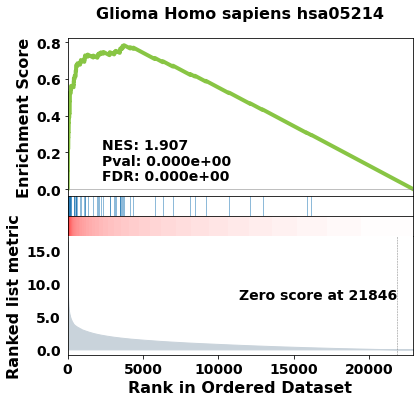

In [22]:
## easy way
from gseapy import gseaplot
terms = pre_res.res2d.Term
i = 1
# to save your figure, make sure that ofname is not None
gseaplot(rank_metric=pre_res.ranking, 
         term=terms[i], 
         **pre_res.results[terms[i]])

# save figure
# gseaplot(rank_metric=pre_res.ranking, term=terms[0], ofname='your.plot.pdf', **pre_res.results[terms[0]])

### 3.2 Command line usage 

You may also want to use prerank in command line

In [23]:
# !gseapy prerank -r temp.rnk -g temp.gmt -o prerank_report_temp

## 4. GSEA Example


### 4.1 Inputs 

Assign gsea() 

- data with: 
  - pandas DataFrame
  - .gct format file, or a text file

- cls with: 
  - a list
  - a .cls format file 

- gene_sets with:
    ```python
        gene_sets="KEGG_2016",
        gene_sets="KEGG_2016,KEGG2013",
        gene_sets="./data/genes.gmt",
        gene_sets=["KEGG_2016","./data/genes.gmt"],
        gene_sets={'A':['gene1', 'gene2',...],
                   'B':['gene2', 'gene4',...],
                   ...}
    ```

In [24]:
phenoA, phenoB, class_vector =  gp.parser.gsea_cls_parser("./tests/extdata/Leukemia.cls")

In [25]:
#class_vector used to indicate group attributes for each sample
print(class_vector)

['ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML']


In [26]:
gene_exp = pd.read_csv("./tests/extdata/Leukemia_hgu95av2.trim.txt", sep="\t")
gene_exp.head()

,Gene,NAME,ALL_1,ALL_2,ALL_3,ALL_4,ALL_5,ALL_6,ALL_7,ALL_8,...,AML_15,AML_16,AML_17,AML_18,AML_19,AML_20,AML_21,AML_22,AML_23,AML_24
0,MAPK3,1000_at,1633.6,2455.0,866.0,1000.0,3159.0,1998.0,1580.0,1955.0,...,1826.0,2849.0,2980.0,1442.0,3672.0,294.0,2188.0,1245.0,1934.0,13154.0
1,TIE1,1001_at,284.4,159.0,173.0,216.0,1187.0,647.0,352.0,1224.0,...,1556.0,893.0,1278.0,301.0,797.0,248.0,167.0,941.0,1398.0,-502.0
2,CYP2C19,1002_f_at,285.8,114.0,429.0,-43.0,18.0,366.0,119.0,-88.0,...,-177.0,64.0,-359.0,68.0,2.0,-464.0,-127.0,-279.0,301.0,509.0
3,CXCR5,1003_s_at,-126.6,-388.0,143.0,-915.0,-439.0,-371.0,-448.0,-862.0,...,237.0,-834.0,-1940.0,-684.0,-1236.0,-1561.0,-895.0,-1016.0,-2238.0,-1362.0
4,CXCR5,1004_at,-83.3,33.0,195.0,85.0,54.0,-6.0,55.0,101.0,...,86.0,-5.0,487.0,102.0,33.0,-153.0,-50.0,257.0,439.0,386.0


In [27]:
print("positively correlated: ", phenoA)

positively correlated:  ALL


In [28]:
print("negtively correlated: ", phenoB)

negtively correlated:  AML


In [29]:
# run gsea
# enrichr libraries are supported by gsea module. Just provide the name
gs_res = gp.gsea(data=gene_exp, # or data='./P53_resampling_data.txt'
                 gene_sets='./tests/extdata/h.all.v7.0.symbols.gmt', # enrichr library names
                 cls= "./tests/extdata/Leukemia.cls", # cls=class_vector
                 # set permutation_type to phenotype if samples >=15
                 permutation_type='phenotype', 
                 permutation_num=1000, # reduce number to speed up test
                 outdir=None,  # do not write output to disk
                 method='signal_to_noise',
                 threads=4, seed= 7)

2022-08-17 15:26:35,011 Warning: dropping duplicated gene names, only keep the first values


In [30]:
#access the dataframe results throught res2d attribute
gs_res.res2d.head()

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,HALLMARK_E2F_TARGETS,0.574187,1.661335,0.052521,0.346311,0.345,87/200,23.65%,DCK;BARD1;NASP;SRSF2;STMN1;SRSF1;TRA2B;EZH2;SM...
1,gsea,HALLMARK_MITOTIC_SPINDLE,0.430183,1.646924,0.026804,0.269703,0.37,74/199,31.44%,SPTAN1;SEPT9;ATG4B;SMC1A;MYH10;BIN1;CYTH2;TUBG...
2,gsea,HALLMARK_WNT_BETA_CATENIN_SIGNALING,0.438876,1.586567,0.013834,0.290456,0.483,10/42,16.91%,LEF1;SKP2;HDAC2;GNAI1;CUL1;MAML1;WNT1;HDAC5;AX...
3,gsea,HALLMARK_MYC_TARGETS_V1,0.535105,1.519305,0.156448,0.34979,0.635,111/200,31.98%,HNRNPA3;HDDC2;RFC4;SRSF2;SRSF1;TRA2B;RRM1;HNRN...
4,gsea,HALLMARK_G2M_CHECKPOINT,0.438496,1.517946,0.094845,0.296259,0.637,80/200,28.04%,MTF2;BARD1;NASP;CUL5;SRSF2;STMN1;NUP50;SRSF1;O...


### 4.2 Show the gsea plots

The **gsea** module will generate heatmap for genes in each gene sets in the backgroud.  
But if you need to do it yourself, use the code below

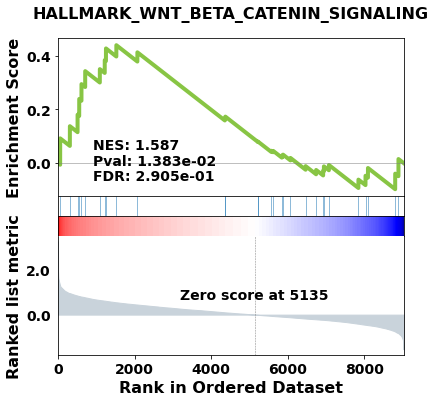

In [31]:
from gseapy import gseaplot, heatmap
terms = gs_res.res2d.Term
i = 2
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
gseaplot(gs_res.ranking, term=terms[i], **gs_res.results[terms[i]])

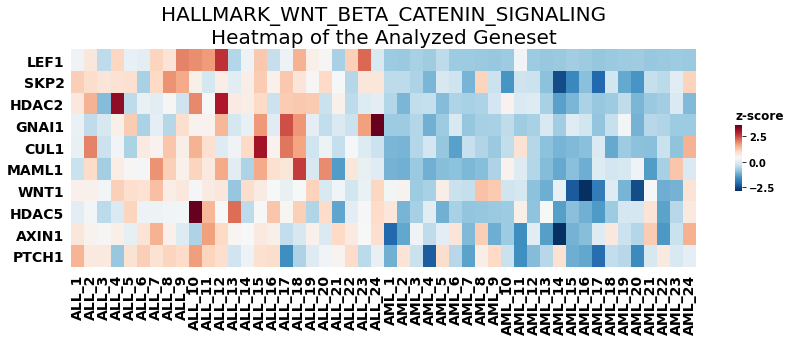

In [32]:
# plotting heatmap
genes = gs_res.res2d.Lead_genes[i].split(";")
# Make sure that ``ofname`` is not None, if you want to save your figure to disk
heatmap(df = gs_res.heatmat.loc[genes], z_score=0, title=terms[i], figsize=(14,4), cmap=plt.cm.RdBu_r)

### 4.3 Command line usage 

You may also want to use gsea in command line

In [33]:
# !gseapy gsea -d ./data/P53_resampling_data.txt \
#              -g KEGG_2016 -c ./data/P53.cls \
#              -o test/gsea_reprot_2 \
#              -v --no-plot \
#              -t phenotype

## 5. Single Sample GSEA example

**Note: When you run ssGSEA, all genes names in your gene_sets file should be found in your expression table**

What's ssGSEA? Which one should I use? Prerank or ssGSEA

see FAQ [here](https://github.com/zqfang/GSEApy/wiki/FAQ)


### 5.1 Input format  
Assign 
- `data` with 
  - a txt file, gct file, 
  - pd.DataFrame
  - pd.Seires(gene name as index)
  
- gene_sets with:
    ```python
        gene_sets="KEGG_2016",
        gene_sets="KEGG_2016,KEGG2013",
        gene_sets="./data/genes.gmt",
        gene_sets=["KEGG_2016","./data/genes.gmt"],
        gene_sets={'A':['gene1', 'gene2',...],
                   'B':['gene2', 'gene4',...],
                   ...}
    ```

In [34]:
# txt, gct file input
ss = gp.ssgsea(data=gene_exp, # or data='./P53_resampling_data.txt'
               gene_sets='./tests/extdata/h.all.v7.0.symbols.gmt',
               outdir=None, 
               sample_norm_method='rank', # choose 'custom' for your own rank list
               no_plot=True)

2022-08-17 15:26:41,478 Warning: dropping duplicated gene names, only keep the first values


In [35]:
ss.res2d.head()

,Name,Term,ES,NES,Tag %,Gene %,Lead_genes
0,ALL_1,HALLMARK_APOPTOSIS,2150.536346,0.230613,63/161,30.45%,IFITM3;HMGB2;TXNIP;TSPO;BCAP31;ISG20;MCL1;LEF1...
1,ALL_2,HALLMARK_APOPTOSIS,2083.467531,0.223421,75/161,42.03%,HMGB2;TSPO;IFITM3;LEF1;VDAC2;BCAP31;CCND2;TXNI...
2,ALL_3,HALLMARK_APOPTOSIS,2774.592204,0.297533,91/161,43.51%,HMGB2;IFITM3;MCL1;CTNNB1;TXNIP;CD69;GNA15;SAT1...
3,ALL_4,HALLMARK_APOPTOSIS,2838.068503,0.30434,65/161,27.53%,HMGB2;IFITM3;SOD1;TSPO;BTG2;MCL1;CD69;EGR3;LEF...
4,ALL_5,HALLMARK_APOPTOSIS,1907.319256,0.204531,118/161,70.30%,IFITM3;SATB1;SOD1;TXNIP;BCAP31;GNA15;LEF1;HMGB...


In [36]:
# or assign a dataframe, or Series to ssgsea()
ssdf = pd.read_csv("./tests/data/temp.rnk", header=None,index_col=0,  sep="\t")
ssdf.head()

,1
0,
ATXN1,16.456753
UBQLN4,13.989493
CALM1,13.745533
DLG4,12.796588
MRE11A,12.787631


In [37]:
# dataframe with one column is also supported by ssGSEA or Prerank
# But you have to set gene_names as index
ssdf2 = ssdf.squeeze()

In [38]:
# Series, DataFrame Example
# supports dataframe and series
import gseapy as gp
temp  = gp.ssgsea(data=ssdf2, gene_sets="./tests/data/temp.gmt")

### 5.2 Access Enrichment Score (ES) and NES

results are saved to obj.res2d

In [39]:
# NES and ES
ss.res2d.sort_values('Name').head()

,Name,Term,ES,NES,Tag %,Gene %,Lead_genes
0,ALL_1,HALLMARK_APOPTOSIS,2150.536346,0.230613,63/161,30.45%,IFITM3;HMGB2;TXNIP;TSPO;BCAP31;ISG20;MCL1;LEF1...
768,ALL_1,HALLMARK_ADIPOGENESIS,3088.841987,0.331232,74/200,30.14%,UQCRQ;TKT;COX8A;ATP1B3;UBC;ALDOA;ATP5PO;ACADM;...
1776,ALL_1,HALLMARK_BILE_ACID_METABOLISM,-730.307913,-0.078315,73/112,73.76%,LIPE;SLC22A18;CYP27A1;ABCD1;SLC29A1;EPHX2;KLF1...
816,ALL_1,HALLMARK_DNA_REPAIR,3926.820514,0.421093,89/150,45.86%,DUT;SRSF6;BCAP31;HCLS1;TMED2;ARL6IP1;PCNA;ZWIN...
864,ALL_1,HALLMARK_MTORC1_SIGNALING,3684.452357,0.395102,96/200,28.28%,PGK1;CXCR4;PRDX1;IDI1;XBP1;GAPDH;ENO1;EDEM1;PP...


In [40]:
nes = ss.res2d.pivot(index='Term', columns='Name', values='NES')
nes.head()

Name,ALL_1,ALL_10,ALL_11,ALL_12,ALL_13,ALL_14,ALL_15,ALL_16,ALL_17,ALL_18,...,AML_22,AML_23,AML_24,AML_3,AML_4,AML_5,AML_6,AML_7,AML_8,AML_9
Term,,,,,,,,,,,,,,,,,,,,,
HALLMARK_ADIPOGENESIS,0.331232,0.329075,0.330213,0.343893,0.362546,0.355699,0.334983,0.306043,0.371784,0.347331,...,0.303826,0.292327,0.221319,0.354471,0.397949,0.2832,0.334483,0.458101,0.457889,0.39459
HALLMARK_ALLOGRAFT_REJECTION,0.082237,0.059431,0.11801,0.119965,0.11086,0.138031,0.161082,0.165426,0.165237,0.13461,...,0.192159,0.160571,0.070941,0.236232,0.200142,0.21796,0.182224,0.168223,0.149031,0.134662
HALLMARK_ANDROGEN_RESPONSE,0.144927,0.136943,0.211038,0.233724,0.16325,0.159404,0.188494,0.138497,0.212663,0.209312,...,0.181847,0.195235,0.11322,0.195834,0.174462,0.189198,0.16957,0.190042,0.229602,0.21032
HALLMARK_ANGIOGENESIS,-0.110603,-0.169102,-0.16132,-0.074429,-0.189447,-0.078742,-0.073851,-0.129031,-0.062332,-0.125366,...,0.01231,-0.044895,0.067698,-0.090903,0.042762,0.010191,0.060879,-0.040782,0.003717,-0.040145
HALLMARK_APICAL_JUNCTION,0.09589,0.11086,0.102473,0.072587,0.094981,0.091434,0.110588,0.091577,0.098605,0.116882,...,0.134789,0.115729,0.14266,0.133337,0.164631,0.155894,0.17089,0.146885,0.131404,0.139515


** Warning !!!**

if you set permutation_num > 0, ssgsea will become `prerank` with ssGSEA statistics. Do use this, unless you known what you are doing !

```python
ss_permut = gp.ssgsea(data="./tests/extdata/Leukemia_hgu95av2.trim.txt",
               gene_sets="./tests/extdata/h.all.v7.0.symbols.gmt", 
               outdir=None, 
               sample_norm_method='rank', # choose 'custom' for your own rank list
               permutation_num=20, # skip permutation procedure, because you don't need it
               no_plot=True, # skip plotting, because you don't need these figures
               processes=4, seed=9)
ss_permut.res2d.head(5)
```

### 5.3 command line usage of single sample gsea

In [41]:
# !gseapy ssgsea -d ./data/testSet_rand1200.gct \
#                -g data/temp.gmt \
#                -o test/ssgsea_report2  \
#                -p 4 --no-plot 

## 6. Replot Example

### 6.1 locate your directory

notes: ``replot`` module need to find edb folder to work properly.
keep the file tree like this:
```
data
 |--- edb
 |    |--- C1OE.cls
 |    |--- gene_sets.gmt
 |    |--- gsea_data.gsea_data.rnk
 |    |--- results.edb

```

In [42]:
# run command inside python console
rep = gp.replot(indir="./tests/data", outdir="test/replot_test")

### 6.2 command line usage of replot

In [43]:
# !gseapy replot -i data -o test/replot_test